<a href="https://colab.research.google.com/github/priyankachaudhari08/Frisbee-Data-Dynamics/blob/main/BostonGloryMidterm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Frisbee Data Dynamics**

**Team Members: Audrey Sellers, Mohamad Ali Saadeddine, Priyanka Chaudhari**

## **Problem Statement and Scope**

**Problem**
Ultimate Frisbee has not yet fully tapped into the extensive data available for making strategic decisions. The primary objective of this project is to enhance the performance of the Boston Glory frisbee team by leveraging data analytics to generate actionable insights. The focus is on identifying key areas of offensive and defensive strengths and weaknesses and suggesting on-field strategies that can lead to victories and championships in the UFA league.

**Project Scope**
This project will cover data collection and preprocessing, exploratory data analysis, feature engineering, and the development of machine learning models. The data will be sourced from the UFA API and processed using Google Cloud infrastructure, including Google Big Query for data storage and analysis. The aim is to analyze various performance metrics, such as points per game, yards received, and defensive shortcomings, to provide comprehensive insights for improving the team's strategies.



##**Import Libraries**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import pandas as pd
import json
from urllib import request
import os
import pandas_gbq
from google.oauth2 import service_account
import functions_framework

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Data Collection and Preprocessing:**

####We source our data from UFA API. We build a low cost, easily managed ETL infrastructure(Google Cloud Function) to automate ingestion of the data for year 2023 and 2024 from these sources into our Data Warehouse(Google Big Query) and event triggers to update dashboards and models.


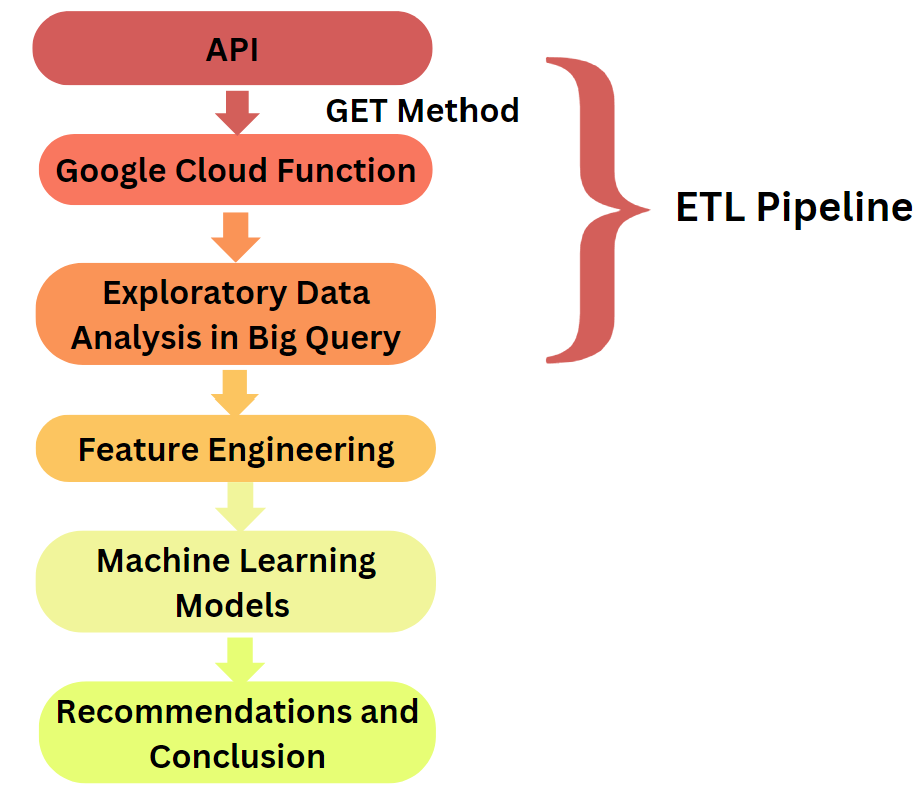

Fetching data from API through GET method in Google Cloud Function and ingested in Google BigQuery. Following are the function calls for all the datasets

## **Game Dataset**

In [ ]:

TABLE_ID = "boston-glory-analytics.audl.games2"
PROJECT_ID = "boston-glory-analytics"

def get_credentials():
    credentials = service_account.Credentials.from_service_account_file("boston_glory.json")
    return credentials

def process_api_call(response):
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Failed to fetch data. Status code: {response.status_code}")
        print(response.text)

def make_ufa_games_request(year):
    url = 'https://www.backend.ufastats.com/api/v1/games'
    params = {
        'date': f'{year}',
    }
    response = requests.get(url, params=params)
    return response

def get_ufa_games_data(year):
    response = make_ufa_games_request(year)
    data = process_api_call(response)
    return data

def make_games_dataframe(years=[2023, 2024]):
    all_games_data = []

    for year in years:
        game_data = get_ufa_games_data(year)
        json_data = game_data['data']

        for game in json_data:
            game['year'] = year
            all_games_data.append(game)

    df_game_data = pd.DataFrame(all_games_data)
    return df_game_data

def bigquery_ingress(df, TABLE_ID, PROJECT_ID, credentials):
    pandas_gbq.to_gbq(
        df, TABLE_ID, project_id=PROJECT_ID, if_exists="replace", credentials=credentials
    )

@functions_framework.http
def hello_http(request):
    ### Get the data:
    print("Entry")
    df = make_games_dataframe()
    print("Got data")

    ### Drop the 'year' column
    df = df.drop(columns=['year'])
    print("Dropped 'year' column")

    ### Get service account credentials
    credentials = get_credentials()
    print("Got credentials")

    ### Ingress to bigquery
    bigquery_ingress(df, TABLE_ID, PROJECT_ID, credentials)
    print("Loaded BQ")
    return "Complete!"


##**Players Dataset**

In [ ]:

TABLE_ID = "boston-glory-analytics.audl.players2"
PROJECT_ID = "boston-glory-analytics"

def get_credentials():
    credentials = service_account.Credentials.from_service_account_file("boston_glory.json")
    return credentials

def process_api_call(response):
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Failed to fetch data. Status code: {response.status_code}")
        print(response.text)

def make_ufa_players_request(year):
    url = f'https://www.backend.ufastats.com/api/v1/players?years={year}'
    response = requests.get(url)
    return response

def get_ufa_players_data(year):
    response = make_ufa_players_request(year)
    data = process_api_call(response)
    return data

def make_players_dataframe(years=[2023, 2024]):
    all_players_data = []

    for year in years:
        players = get_ufa_players_data(year)
        players = players['data']

        for player in players:
            for team in player.get('teams', []):
                player_pk = f"{player['playerID']}{team['teamID']}{year}"
                team_pk = f"{team['teamID']}{year}"
                row_data = {
                    'playerPK': player_pk,
                    'teamPK': team_pk,
                    'year': year,
                    'playerID': player['playerID'],
                    'firstName': player['firstName'],
                    'lastName': player['lastName'],
                    'teamID': team['teamID'],
                    'jerseyNumber': team.get('jerseyNumber', None)
                }
                all_players_data.append(row_data)

    players_df = pd.DataFrame(all_players_data)

    # Drop columns that contain 'active' in their names
    players_df = players_df.loc[:, ~players_df.columns.str.contains('active')]

    return players_df

def bigquery_ingress(df, TABLE_ID, PROJECT_ID, credentials):
    pandas_gbq.to_gbq(df, TABLE_ID, project_id=PROJECT_ID, if_exists="replace", credentials=credentials)

@functions_framework.http
def hello_http(request):
    ### Get the data:
    print("Entry")
    df = make_players_dataframe()
    print("Got data")
    ### Get service account credentials
    credentials = get_credentials()
    print("Got credentials")
    ### Ingress to bigquery
    bigquery_ingress(df, TABLE_ID, PROJECT_ID, credentials)
    print("Loaded BQ")
    return "Complete!"


##**Teams Dataset**

In [ ]:

TABLE_ID = "boston-glory-analytics.audl.teams2"
PROJECT_ID = "boston-glory-analytics"

def get_credentials():
    credentials = service_account.Credentials.from_service_account_file("boston_glory.json")
    return credentials

def process_api_call(response):
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Failed to fetch data. Status code: {response.status_code}")
        print(response.text)
        return None

def make_ufa_teams_request(year):
    url = 'https://www.backend.ufastats.com/api/v1/teams'
    params = {'years': f'{year}'}
    response = requests.get(url, params=params)
    return response

def get_ufa_teams_data(year):
    response = make_ufa_teams_request(year)
    data = process_api_call(response)
    return data

def make_teams_dataframe(years):
    all_teams_data = []

    for year in years:
        teams_data = get_ufa_teams_data(year)
        if not teams_data:
            continue
        json_data = teams_data.get('data', [])
        for team in json_data:
            team['year'] = year
            all_teams_data.append(team)

    if not all_teams_data:
        print("No teams data found for the specified years.")
        return pd.DataFrame()

    df_teams = pd.json_normalize(all_teams_data, sep='_')
    return df_teams

def bigquery_ingress(df, TABLE_ID, PROJECT_ID, credentials):
    pandas_gbq.to_gbq(df, TABLE_ID, project_id=PROJECT_ID, if_exists="replace", credentials=credentials)

@functions_framework.http
def driver_function(request):
    ### Get the data:
    print("Entry")
    df = make_teams_dataframe([2023, 2024])
    if df.empty:
        print("No data to load into BigQuery.")
        return "No data to load into BigQuery."
    print("Got data")
    ### Get service account credentials
    credentials = get_credentials()
    print("Got credentials")
    ### Ingress to bigquery
    bigquery_ingress(df, TABLE_ID, PROJECT_ID, credentials)
    print("Loaded BQ")
    return "Complete!"


##**Events Dataset**

In [ ]:

TABLE_ID = "boston-glory-analytics.audl.games_events2"
PROJECT_ID = "boston-glory-analytics"

def get_credentials():
    credentials = service_account.Credentials.from_service_account_file("boston_glory.json")
    return credentials

def process_api_call(response):
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Failed to fetch data. Status code: {response.status_code}")
        print(response.text)

def make_ufa_games_request(year):
    url = 'https://www.backend.ufastats.com/api/v1/games'
    params = {
        'date': f'{year}',
    }
    response = requests.get(url, params=params)
    return response

def get_ufa_games_data(year):
    response = make_ufa_games_request(year)
    data = process_api_call(response)
    return data

def get_ufa_game_ids(year):
    data_json = get_ufa_games_data(year)
    data = data_json['data']
    gameids = []
    for i in range(len(data)):
        gameids.append(data[i]['gameID'])
    return gameids

def make_ufa_gameEvents_request(gameids):
    url = 'https://www.backend.ufastats.com/api/v1/gameEvents'
    params = {
        'gameID': gameids
    }
    response = requests.get(url, params=params)
    return response

def get_ufa_gameEvents_data(year):
    gameids = get_ufa_game_ids(year)
    response = make_ufa_gameEvents_request(gameids)
    data = process_api_call(response)
    return data

def make_events_dataframe(years=[2023, 2024]):
    all_event_data = []

    for year in years:
        gameEvents = get_ufa_gameEvents_data(year)
        json_data = gameEvents['data']

        if not isinstance(json_data, list):
            print(f"Unexpected data format for year {year}: {json_data}")
            continue

        for event in json_data:
            if not isinstance(event, dict):
                print(f"Unexpected event format: {event}")
                continue

            all_event_data.append({
                'homeTeam': event.get('homeTeam'),
                'awayTeam': event.get('awayTeam'),
                'type': event['type'],
                'puller': event.get('puller'),
                'pullX': event.get('pullX'),
                'pullY': event.get('pullY'),
                'pullMs': event.get('pullMs'),
                'thrower': event.get('thrower'),
                'throwerX': event.get('throwerX'),
                'throwerY': event.get('throwerY'),
                'receiver': event.get('receiver'),
                'receiverX': event.get('receiverX'),
                'receiverY': event.get('receiverY'),
                'defender': event.get('defender'),
                'turnoverX': event.get('turnoverX'),
                'turnoverY': event.get('turnoverY'),
                'year': year
            })

    df_game_events = pd.DataFrame(all_event_data)
    return df_game_events


def bigquery_ingress(df, TABLE_ID, PROJECT_ID, credentials):
    pandas_gbq.to_gbq(
        df, TABLE_ID, project_id=PROJECT_ID, if_exists="replace", credentials=credentials
    )

@functions_framework.http
def hello_http(request):
    ### Get the data:
    print("Entry")
    df = make_events_dataframe()
    print("Got data")
    ### Get service account credentials
    credentials = get_credentials()
    print("Got credentials")
    ### Ingress to bigquery
    bigquery_ingress(df, TABLE_ID, PROJECT_ID, credentials)
    print("Loaded BQ")
    return "Complete!"


##**Player Game Stat Dataset**

In [ ]:

TABLE_ID = "boston-glory-analytics.audl.playergamestat2"
PROJECT_ID = "boston-glory-analytics"

def get_credentials():
    credentials = service_account.Credentials.from_service_account_file("boston_glory.json")
    return credentials

def process_api_call(response):
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Failed to fetch data. Status code: {response.status_code}")
        print(response.text)

def make_ufa_games_request(year):
    url = 'https://www.backend.ufastats.com/api/v1/games'
    params = {'date': f'{year}'}
    response = requests.get(url, params=params)
    return response

def get_ufa_games_data(year):
    response = make_ufa_games_request(year)
    data = process_api_call(response)
    return data

def get_ufa_game_ids(year):
    data_json = get_ufa_games_data(year)
    data = data_json['data']
    gameids = [game['gameID'] for game in data]
    return gameids

def make_ufa_playerGameStats_request(gameid):
    url = 'https://www.backend.ufastats.com/api/v1/playerGameStats'
    params = {'gameID': gameid}
    response = requests.get(url, params=params)
    return response

def get_ufa_playerGameStats_data(gameid):
    response = make_ufa_playerGameStats_request(gameid)
    data = process_api_call(response)
    return data

def make_playergamestat_dataframe(years=[2023, 2024]):
    all_playerGameStats_data = []

    for year in years:
        gameids = get_ufa_game_ids(year)

        for gameid in gameids:
            playerGameStats = get_ufa_playerGameStats_data(gameid)
            json_data = playerGameStats['data']

            for stat in json_data:
                stat['year'] = year
                stat['gameID'] = gameid  # Add gameID to each player's stats
                all_playerGameStats_data.append(stat)

    df_playerGameStats = pd.json_normalize(all_playerGameStats_data)

    # Rename columns
    df_playerGameStats.rename(columns={
        'player.playerID': 'playerID',
        'player.firstName': 'firstName',
        'player.lastName': 'lastName'
    }, inplace=True)

    return df_playerGameStats

def bigquery_ingress(df, TABLE_ID, PROJECT_ID, credentials):
    pandas_gbq.to_gbq(df, TABLE_ID, project_id=PROJECT_ID, if_exists="replace", credentials=credentials)

@functions_framework.http
def hello_http(request):
    ### Get the data:
    print("Entry")
    df = make_playergamestat_dataframe()
    print("Got data")
    ### Get service account credentials
    credentials = get_credentials()
    print("Got credentials")
    ### Ingress to bigquery
    bigquery_ingress(df, TABLE_ID, PROJECT_ID, credentials)
    print("Loaded BQ")
    return "Complete!"


## **Players Stat Dataset**

In [ ]:

TABLE_ID = "boston-glory-analytics.audl.playerstat2"
PROJECT_ID = "boston-glory-analytics"

def get_credentials():
    credentials = service_account.Credentials.from_service_account_file("boston_glory.json")
    return credentials

def process_api_call(response):
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Failed to fetch data. Status code: {response.status_code}")
        print(response.text)
        return None

def make_ufa_games_request(year):
    url = 'https://www.backend.ufastats.com/api/v1/games'
    params = {'date': f'{year}'}
    response = requests.get(url, params=params)
    return response

def get_ufa_games_data(year):
    response = make_ufa_games_request(year)
    data = process_api_call(response)
    return data

def get_ufa_game_ids(year):
    data_json = get_ufa_games_data(year)
    if not data_json:
        print(f"No data found for games in year {year}")
        return []
    data = data_json.get('data', [])
    gameids = [game['gameID'] for game in data]
    return gameids

def make_ufa_players_request(year):
    url = 'https://www.backend.ufastats.com/api/v1/players'
    params = {'years': f'{year}'}
    response = requests.get(url, params=params)
    return response

def get_ufa_players_data(year):
    response = make_ufa_players_request(year)
    data = process_api_call(response)
    return data

def get_ufa_player_ids(year):
    data_json = get_ufa_players_data(year)
    if not data_json:
        print(f"No data found for players in year {year}")
        return []
    data = data_json.get('data', [])
    playerids = [player['playerID'] for player in data]
    return playerids

def make_ufa_playerStats_request(playerids):
    url = 'https://www.backend.ufastats.com/api/v1/playerStats'
    params = {'playerIDs': playerids}
    response = requests.get(url, params=params)
    return response

def get_ufa_playerStats_data(playerids):
    response = make_ufa_playerStats_request(playerids)
    data = process_api_call(response)
    return data

def make_playerstat_dataframe(years=[2023, 2024]):
    all_playerStats_data = []

    for year in years:
        playerids = get_ufa_player_ids(year)
        if not playerids:
            continue
        playerStats = get_ufa_playerStats_data(playerids)
        if not playerStats:
            continue
        json_data = playerStats.get('data', [])
        for stat in json_data:
            stat['year'] = year
            all_playerStats_data.append(stat)

    if not all_playerStats_data:
        print("No player stats data found for the specified years.")
        return pd.DataFrame()

    df_playerStats = pd.json_normalize(all_playerStats_data)

    # Rename columns
    df_playerStats.rename(columns={
        'player.playerID': 'playerID',
        'player.firstName': 'firstName',
        'player.lastName': 'lastName'
    }, inplace=True)

    return df_playerStats

def bigquery_ingress(df, TABLE_ID, PROJECT_ID, credentials):
    pandas_gbq.to_gbq(df, TABLE_ID, project_id=PROJECT_ID, if_exists="replace", credentials=credentials)

@functions_framework.http
def hello_http(request):
    ### Get the data:
    print("Entry")
    df = make_playerstat_dataframe()
    if df.empty:
        print("No data to load into BigQuery.")
        return "No data to load into BigQuery."
    print("Got data")

    ### Drop the 'year' column
    df.drop(columns=['year'], inplace=True)
    print("Dropped 'year' column")

    ### Get service account credentials
    credentials = get_credentials()
    print("Got credentials")

    ### Ingress to bigquery
    bigquery_ingress(df, TABLE_ID, PROJECT_ID, credentials)
    print("Loaded BQ")
    return "Complete!"


## **Exploratory Data Analysis in BigQuery**

#Queries

In [ ]:
# 1. Basic Overview
SELECT *
FROM `boston-glory-analytics.audl.playerseasonstats`
LIMIT 10;

In [ ]:
# 2. Total # of Games Played by Each Player
SELECT playerID, firstName, lastName, teamID, SUM(games) AS total_games
FROM `boston-glory-analytics.audl.playerseasonstats`
GROUP BY playerID, firstName, lastName, teamID
ORDER BY total_games DESC;

In [ ]:
# 3. Total Goals Scored by Player
SELECT playerID, firstName, lastName, teamID, SUM(goals) AS total_goals
FROM `boston-glory-analytics.audl.playerseasonstats`
GROUP BY playerID, firstName, lastName, teamID
ORDER BY total_goals DESC;

In [ ]:
# 4. Top 10 Players by Assist
SELECT playerID, firstName, lastName, teamID, SUM(assists) AS total_assists
FROM `boston-glory-analytics.audl.playerseasonstats`
GROUP BY playerID, firstName, lastName, teamID
ORDER BY total_assists DESC
LIMIT 10;

In [ ]:
# 5. Avg Completions Per Game for Each Player
SELECT playerID, firstName, lastName, teamID, AVG(completions) AS avg_completions_per_game
FROM `boston-glory-analytics.audl.playerseasonstats`
GROUP BY playerID, firstName, lastName, teamID
ORDER BY avg_completions_per_game DESC;

In [ ]:
# 6. Top 10 Players by Defense Points Scored
SELECT playerID, firstName, lastName, teamID, SUM(dPointsScored) AS total_d_points_scored
FROM `boston-glory-analytics.audl.playerseasonstats`
GROUP BY playerID, firstName, lastName, teamID
ORDER BY total_d_points_scored DESC
LIMIT 10;


In [ ]:
# 7. Total Offensive and Defense Opps for Each Team
SELECT teamID,
       SUM(oOpportunities) AS total_o_opportunities,
       SUM(dOpportunities) AS total_d_opportunities
FROM `boston-glory-analytics.audl.playerseasonstats`
GROUP BY teamID
ORDER BY teamID;

In [ ]:
# 8. Players with the Most Seconds
SELECT playerID, firstName, lastName, teamID, SUM(secondsPlayed) AS total_seconds_played
FROM `boston-glory-analytics.audl.playerseasonstats`
GROUP BY playerID, firstName, lastName, teamID
ORDER BY total_seconds_played DESC;

In [ ]:
# 9. Avg Points Scored Per Game by Each Player
SELECT playerID, firstName, lastName, teamID, AVG(oPointsScored + dPointsScored) AS avg_points_per_game
FROM `boston-glory-analytics.audl.playerseasonstats`
GROUP BY playerID, firstName, lastName, teamID
ORDER BY avg_points_per_game DESC;

In [ ]:
# 10. Distribution of Recorded Pulls Hangtime by Players
SELECT playerID, firstName, lastName, teamID, recordedPullsHangtime
FROM `boston-glory-analytics.audl.playerseasonstats`
WHERE recordedPullsHangtime > 0
ORDER BY recordedPullsHangtime DESC;

In [ ]:
# 11. Total Goals Scored by Each Team
SELECT teamID, SUM(goals) AS total_goals
FROM `boston-glory-analytics.audl.playerseasonstats`
GROUP BY teamID
ORDER BY total_goals DESC;

In [ ]:
# 12. Avg Assists Per Game for Each Team
SELECT teamID, AVG(assists) AS avg_assists_per_game
FROM `boston-glory-analytics.audl.playerseasonstats`
GROUP BY teamID
ORDER BY avg_assists_per_game DESC;


In [ ]:
# 13. Total Defensive Points Scored by Each Team
SELECT teamID, SUM(dPointsScored) AS total_defensive_points
FROM `boston-glory-analytics.audl.playerseasonstats`
GROUP BY teamID
ORDER BY total_defensive_points DESC;


In [ ]:

# 14. Avg Completions Per Games by Each Team
SELECT teamID, AVG(completions) AS avg_completions_per_game
FROM `boston-glory-analytics.audl.playerseasonstats`
GROUP BY teamID
ORDER BY avg_completions_per_game DESC;


In [ ]:
# 15. Total Offensive and Defense Opps for Each Team
SELECT teamID,
       SUM(oOpportunities) AS total_offensive_opportunities,
       SUM(dOpportunities) AS total_defensive_opportunities
FROM `boston-glory-analytics.audl.playerseasonstats`
GROUP BY teamID
ORDER BY teamID;


In [ ]:
#glorydf:
SELECT
    firstName,
    lastName,
    teamID,
    secondsPlayed,
    yardsReceived,
    completion_percentage,
    goals,
    throwaway_percentage,
    throw_yards_per_attempt,
    yardsThrown,
    yards_per_reception,
    assists,
    (goals * 1.0 / secondsPlayed) AS goals_per_second,
    (goals + assists) AS PPG,
    ((goals + assists) * 1.0 / secondsPlayed) AS points_per_second
FROM
    boston-glory-analytics.audl.playergamestatsADV
WHERE
    secondsPlayed > 0
AND
    teamID = 'glory'
ORDER BY
    points_per_second DESC
;

In [ ]:
#playtime_ppg:
SELECT
    firstName,
    lastName,
    teamID,
    secondsPlayed,
    goals,
    assists,
    (goals * 1.0 / secondsPlayed) AS goals_per_second,
    (goals + assists) AS PPG,
    ((goals + assists) * 1.0 / secondsPlayed) AS points_per_second
FROM
    boston-glory-analytics.audl.playergamestatsADV
WHERE
    secondsPlayed > 0
ORDER BY
    points_per_second DESC
;

In [ ]:
#points_per_game:
SELECT firstName, lastName, teamID, (goals + assists) AS total_points
FROM boston-glory-analytics.audl.playergamestatsADV
ORDER BY total_points DESC

In [ ]:
#defensive_weak_percentage:
SELECT firstName, lastName, teamID,
       (dPointsScored * 1.0 / dPointsPlayed) AS defensive_production
FROM boston-glory-analytics.audl.playergamestatsADV
WHERE dPointsPlayed > 0
ORDER BY defensive_production DESC
;

In [ ]:
#glory_playtime:
SELECT
    firstName,
    lastName,
    teamID,
    secondsPlayed,
    goals,
    assists,
    (goals * 1.0 / secondsPlayed) AS goals_per_second,
    (goals + assists) AS PPG,
    ((goals + assists) * 1.0 / secondsPlayed) AS points_per_second
FROM
    boston-glory-analytics.audl.playergamestatsADV
WHERE
    secondsPlayed > 0
AND
    teamID = 'glory'
ORDER BY
    points_per_second DESC
;

In [ ]:
#glory_defweak:
SELECT firstName, lastName, teamID,
       (dPointsScored * 1.0 / dPointsPlayed) AS defensive_production
FROM boston-glory-analytics.audl.playergamestatsADV
WHERE dPointsPlayed > 0
AND teamID ='glory'
ORDER BY defensive_production DESC
;

##**Analysis based on the results**

In [ ]:

# Overall
defensive_weak_percentage = pd.read_csv('/content/DEFWEAK.csv')
points_per_game = pd.read_csv('/content/TOTALPPG.csv')
playtime_ppg = pd.read_csv('/content/PLAYTIME.csv')

# Glory
glorydf= pd.read_csv('/content/glorydata.csv')
glory_defweak= pd.read_csv('/content/GLORYDEFWEAK.csv')
glory_ppg= pd.read_csv('/content/GLORYPPG.csv')
glory_playtime= pd.read_csv('/content/GLORYPLAYTIME.csv')

# Points Per Game (Goals + Assists)

In [ ]:
glory_ppg

firstName   lastName teamID  total_points
0      Tanner   Halkyard  glory            11
1      Tanner   Halkyard  glory            10
2    Benjamin      Sadok  glory             9
3       Orion      Cable  glory             9
4         Ray  Tetreault  glory             9
..        ...        ...    ...           ...
809   Zachary     Burpee  glory             0
810   Zachary     Burpee  glory             0
811   Zachary     Burpee  glory             0
812   Zachary     Burpee  glory             0
813   Zachary     Burpee  glory             0

[814 rows x 4 columns]

In [ ]:
glory_ppg['total_points'].mean()

1.2702702702702702

Many players have total_points of 0, really skewing the data. With background knowledge, we decided to set a threshold of players scoring at least 5 PPG to be included in the analyzed data. The same threshold is used several times throughout the notebook.

In [ ]:
plus5points = glory_ppg[glory_ppg['total_points'] > 5]
plus5points['total_points'].mean()

7.16

Boston Glory's players score on average 7.16 PPG.

<ipython-input-7-60d9e5577cc1>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='total_points', y='lastName', data=plus5points, palette='Blues_r', ci=None)
<ipython-input-7-60d9e5577cc1>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='total_points', y='lastName', data=plus5points, palette='Blues_r', ci=None)


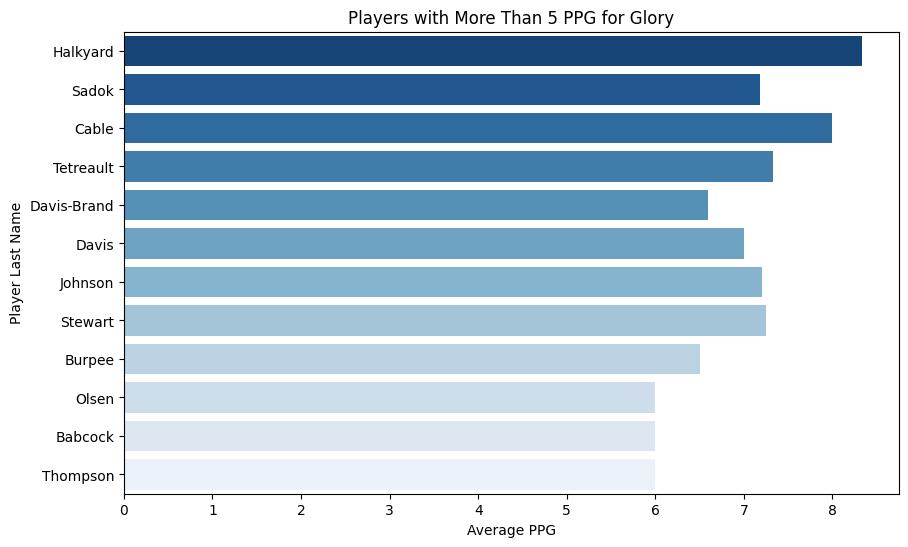

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='total_points', y='lastName', data=plus5points, palette='Blues_r', ci=None)
plt.xlabel('Average PPG')
plt.ylabel('Player Last Name')
plt.title('Players with More Than 5 PPG for Glory')
plt.show()

The top 5 players in scoring for Boston Glory are Halkyard, Cable, Sadok, and Tetrault. Each of them score **at least 7 points** (goals + assists) per game.

In [ ]:
points_per_game

firstName    lastName         teamID  total_points
0        Jordan      Huston        cannons            22
1         Kevin     Quinlan          royal            19
2          Mark      Burton       cascades            18
3         Steve    Armitage           rush            17
4         Tyler  DeGirolamo         breeze            17
...         ...         ...            ...           ...
64338     Tommy         Lin  flamethrowers             0
64339     Tommy         Lin  flamethrowers             0
64340     Tommy         Lin  flamethrowers             0
64341     Tommy         Lin  flamethrowers             0
64342     Tommy         Lin  flamethrowers             0

[64343 rows x 4 columns]

We identified the distribution of PPG amongst the league and saw an imbalance of the data.



In [ ]:
points_per_game['total_points'].value_counts()

total_points
0     22614
1     12601
2      9515
3      6606
4      4559
5      3148
6      2047
7      1306
8       847
9       498
10      303
11      135
12       68
13       35
14       34
15       13
16        7
17        4
19        1
18        1
22        1
Name: count, dtype: int64

In [ ]:
morethan5ppg = points_per_game[points_per_game['total_points'] > 5]
morethan5ppg['total_points'].mean()

7.429811320754717

<ipython-input-11-2215e5e51eaf>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='teamID', y='total_points', data=team_total_points, palette=colors)


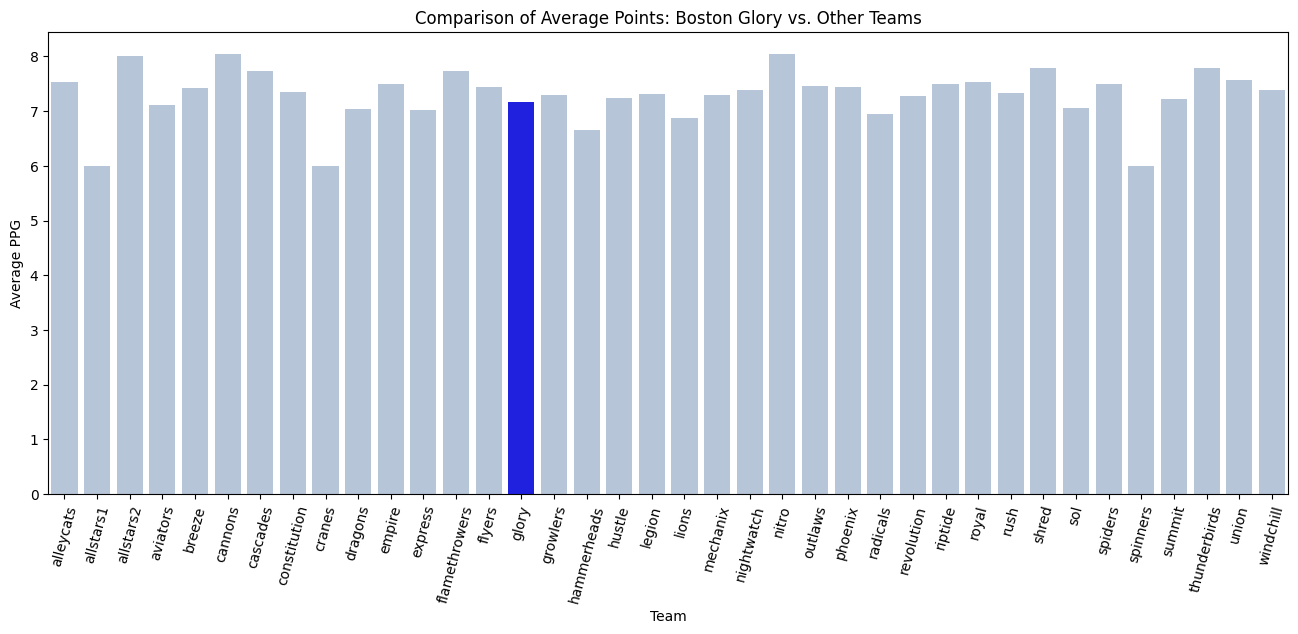

In [ ]:
threshold = 5
morethan5 = points_per_game[points_per_game['total_points'] > threshold]

grouped_df = morethan5.groupby('teamID')

# Calculate mean points for each team
team_total_points = grouped_df['total_points'].mean().reset_index()

colors = ['blue' if team == 'glory' else 'lightsteelblue' for team in team_total_points['teamID']]

plt.figure(figsize=(16, 6))
sns.barplot(x='teamID', y='total_points', data=team_total_points, palette=colors)
plt.xlabel('Team')
plt.ylabel('Average PPG')
plt.title('Comparison of Average Points: Boston Glory vs. Other Teams')
plt.xticks(rotation=75)
plt.show()

After deciding a threshold of 5 points per game to filter out players with less than 5 points, as they skewed the data, we found that Boston Glory scores less Points per Game (Goals + Assists), at **7.16 PPG**, compared to a league average of **7.43 PPG**, indicating a need for **offensive improvement**.

# Defensive Weakness

On average, each player gives up x amount on average of goals on defense per game.

In [ ]:
glory_defweak

firstName  lastName teamID  dPointsScored  dPointsPlayed  \
0      Braden  Eberhard  glory              1              1   
1    Benjamin     Sadok  glory              1              1   
2        Cody   McInnis  glory              1              1   
3        Nick  Thompson  glory              3              3   
4      Topher     Davis  glory              1              1   
..        ...       ...    ...            ...            ...   
363      Ryan    Turner  glory              0              3   
364     Henry   Laseter  glory              0              6   
365      Ivan      Tran  glory              0             18   
366  Kuochuan    Ponzio  glory              0              9   
367   Maxwell      Rick  glory              0             13   

     defensive_production  
0                     1.0  
1                     1.0  
2                     1.0  
3                     1.0  
4                     1.0  
..                    ...  
363                   0.0  
364                   0.0  
365                   0.0  
366                   0.0  
367                   0.0  

[368 rows x 6 columns]

In [ ]:
glory_defweak['defensive_production'].mean()

0.21627571819952343

On average, Boston Glory's defense gives up 0.22 goals per game. This indicates that the defense is strong.

In [ ]:
defensive_weak_percentage

firstName  lastName         teamID  defensive_production
0         Isaac  Jeffries     revolution              8.000000
1         Chris    Powers     revolution              4.666667
2         Chris    Powers     revolution              4.500000
3         Eddie      Mack     revolution              4.000000
4          Jeff      Kula     revolution              3.333333
...         ...       ...            ...                   ...
51595       Sam     Swink  flamethrowers              0.000000
51596     Tommy       Lin  flamethrowers              0.000000
51597     Tommy       Lin  flamethrowers              0.000000
51598     Tommy       Lin  flamethrowers              0.000000
51599     Tommy       Lin  flamethrowers              0.000000

[51600 rows x 4 columns]

In [ ]:
# Set threshold to indicate at least one game played
threshold = 0.1
morethanpoint1 = defensive_weak_percentage[defensive_weak_percentage['defensive_production'] > threshold]
morethanpoint1['defensive_production'].mean()

0.3143262011211762

On average, the UFA gives up 0.39 goals per game.

In [ ]:
defensive_weak_percentage[defensive_weak_percentage['teamID'] == 'glory']

firstName  lastName teamID  defensive_production
241      Braden  Eberhard  glory                   1.0
242    Benjamin     Sadok  glory                   1.0
243        Cody   McInnis  glory                   1.0
244        Nick  Thompson  glory                   1.0
245      Topher     Davis  glory                   1.0
...         ...       ...    ...                   ...
43759      Ryan    Turner  glory                   0.0
43760     Henry   Laseter  glory                   0.0
43761      Ivan      Tran  glory                   0.0
43762  Kuochuan    Ponzio  glory                   0.0
43763   Maxwell      Rick  glory                   0.0

[368 rows x 4 columns]

<ipython-input-18-204ddb536c11>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='teamID', y='defensive_production', data=defensive_weak_percentage, palette=colors, showfliers=False)
<ipython-input-18-204ddb536c11>:4: UserWarning: The palette list has more values (51600) than needed (39), which may not be intended.
  sns.boxplot(x='teamID', y='defensive_production', data=defensive_weak_percentage, palette=colors, showfliers=False)


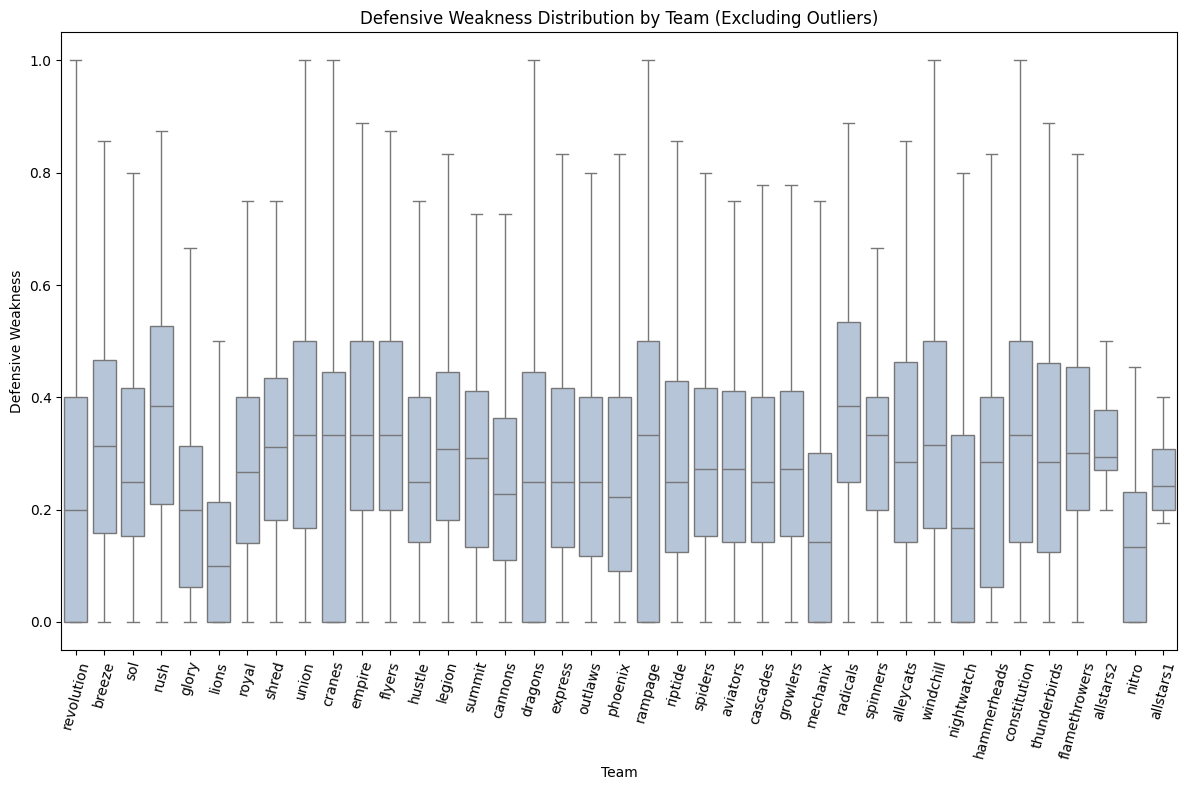

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

In [ ]:
plt.figure(figsize=(12, 8))
colors = ['blue' if team == 'glory' else 'lightsteelblue' for team in defensive_weak_percentage['teamID']]

sns.boxplot(x='teamID', y='defensive_production', data=defensive_weak_percentage, palette=colors, showfliers=False)

plt.title('Defensive Weakness Distribution by Team (Excluding Outliers)')
plt.xlabel('Team')
plt.ylabel('Defensive Weakness')

plt.xticks(rotation=75)

plt.tight_layout()

plt.show()
plt.figure(figsize=(12, 8))

Boston Glory has a strong defense compared to the rest of the league, averaging 0.21 goals scored against versus a 0.39 league average. The limitation on this is the fact that many players do not play every game, so they give up lower amounts of goals. This skews the data. However, setting a threshold of 0.1 defensive weakness shows evidence of at least one game played.

# How is playing time correlated with performance metrics?

In [ ]:
glory_playtime

firstName     lastName teamID  secondsPlayed  goals  assists  \
0      Tanner     Halkyard  glory           1408      6        5   
1      Tanner     Halkyard  glory           1297      6        4   
2      Tanner     Halkyard  glory           1155      5        3   
3        Cole  Davis-Brand  glory            581      1        3   
4      Topher        Davis  glory            888      5        1   
..        ...          ...    ...            ...    ...      ...   
463      Ryan    Woodhouse  glory            538      0        0   
464      Ryan    Woodhouse  glory            909      0        0   
465      Ryan    Woodhouse  glory            885      0        0   
466      Ryan    Woodhouse  glory            552      0        0   
467      Ryan    Woodhouse  glory            666      0        0   

     goals_per_second  PPG  points_per_second  
0            0.004261   11           0.007812  
1            0.004626   10           0.007710  
2            0.004329    8           0.006926  
3            0.001721    4           0.006885  
4            0.005631    6           0.006757  
..                ...  ...                ...  
463          0.000000    0           0.000000  
464          0.000000    0           0.000000  
465          0.000000    0           0.000000  
466          0.000000    0           0.000000  
467          0.000000    0           0.000000  

[468 rows x 9 columns]

<Figure size 1000x200 with 0 Axes>

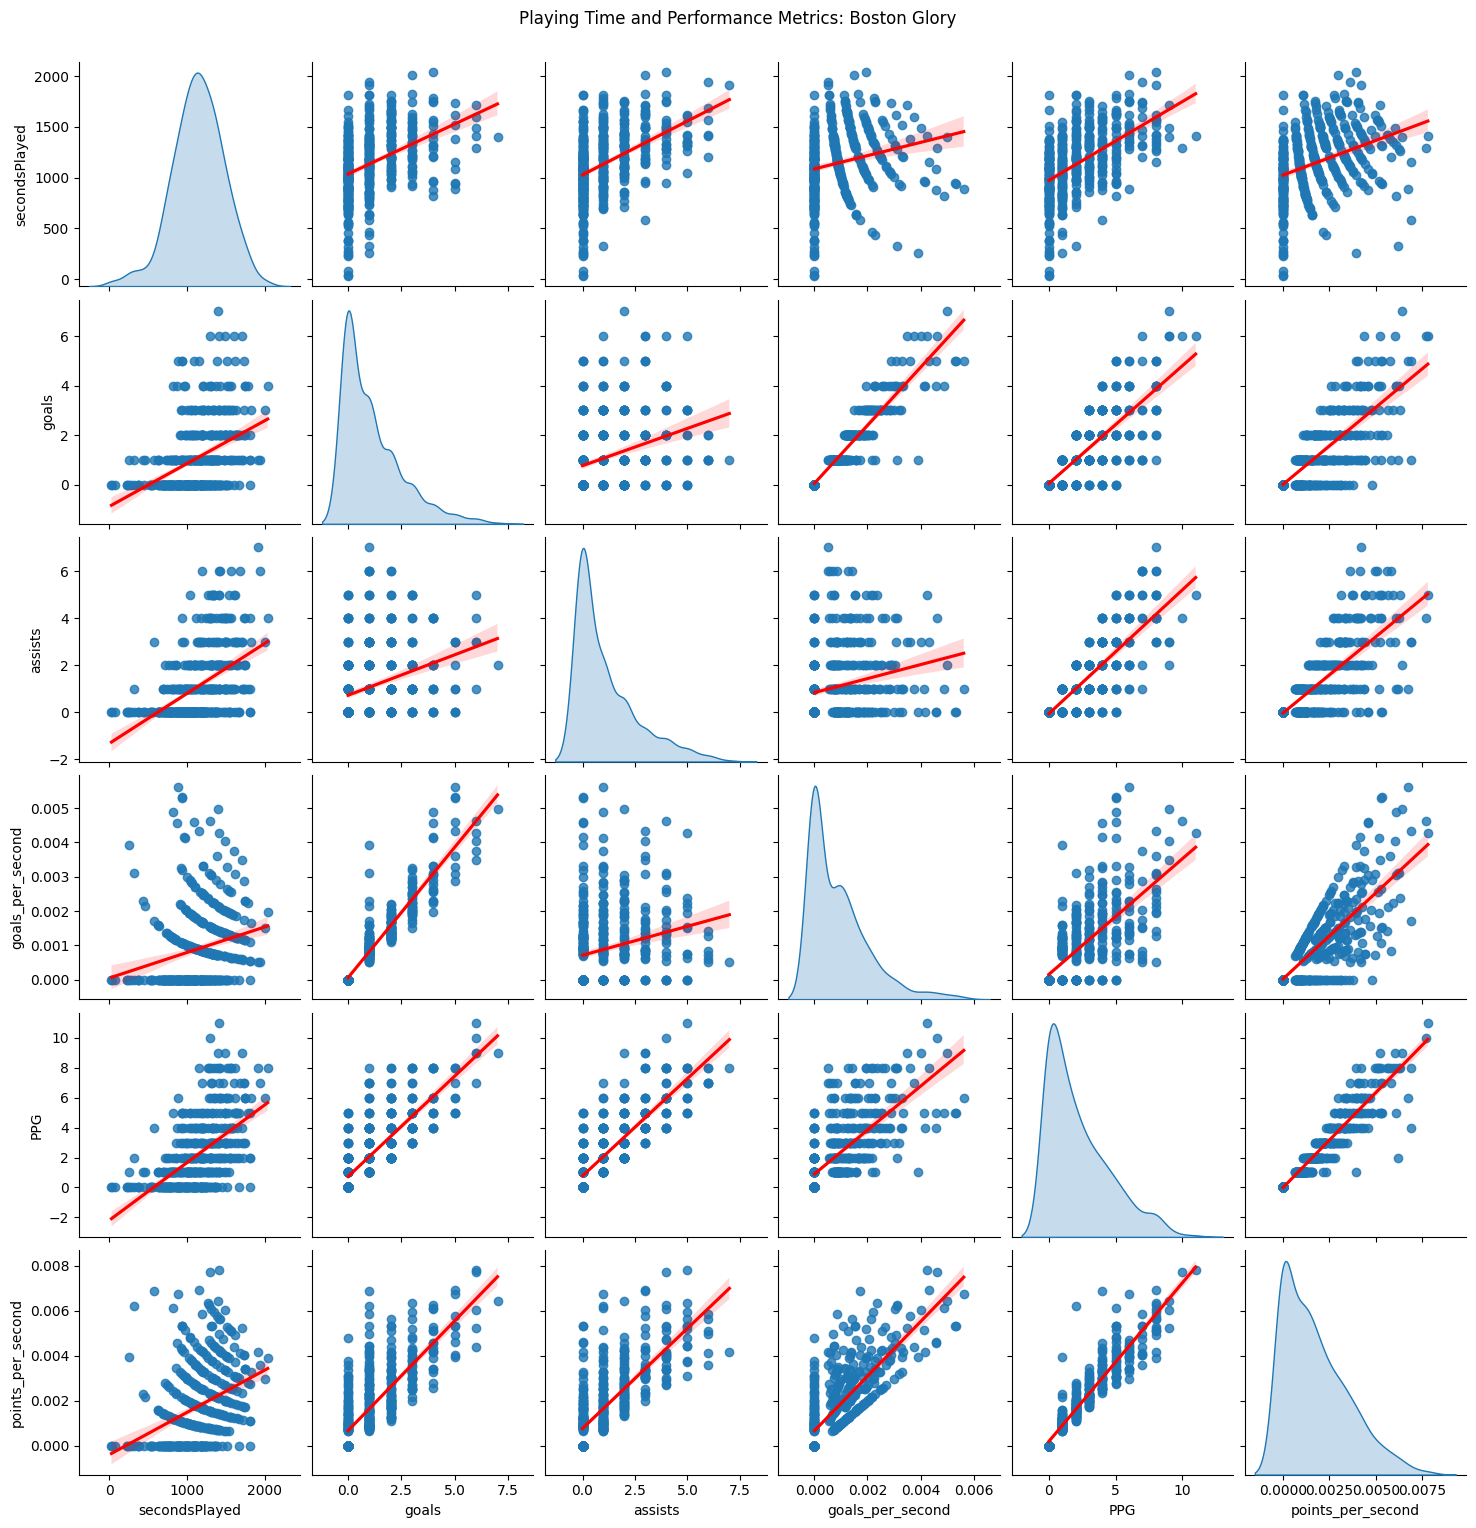

In [ ]:
columns = ['secondsPlayed', 'goals', 'assists', 'goals_per_second', 'PPG', 'points_per_second']
playtime_pairplot = glory_playtime[columns]


plt.figure(figsize=(10, 2))
sns.pairplot(playtime_pairplot, kind='reg', diag_kind='kde', plot_kws={'line_kws':{'color':'red'}})
plt.suptitle('Playing Time and Performance Metrics: Boston Glory', y=1.02)
plt.show()

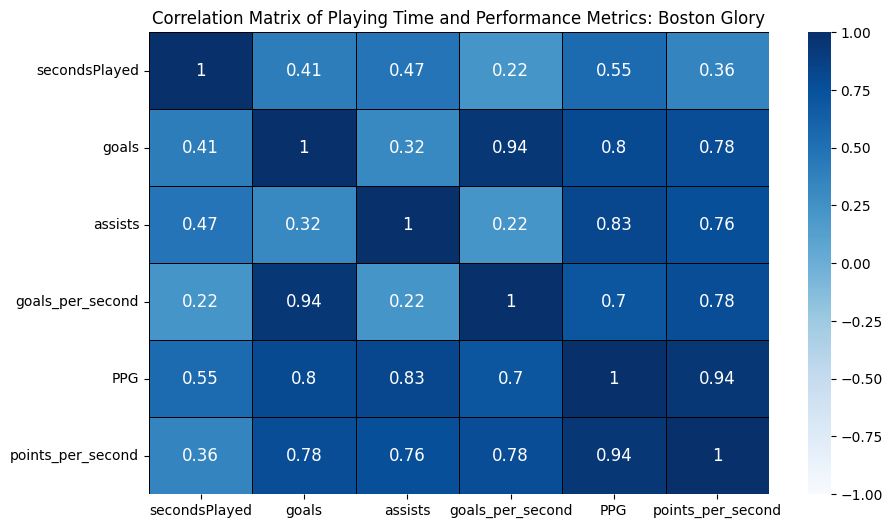

In [ ]:
playtime_corr = glory_playtime[columns]

# Calculating correlation matrix
corr_matrix = playtime_corr.corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', vmin=-1, vmax=1, center=0,
            linewidths=0.5, linecolor='black', annot_kws={'fontsize': 12})
plt.title('Correlation Matrix of Playing Time and Performance Metrics: Boston Glory')
plt.show()

In [ ]:
playtime_ppg

firstName lastName         teamID  secondsPlayed  goals  assists  \
0          Ryan    Segal       cascades             10      0        1   
1         Logan    Weiss      windchill             10      1        0   
2         Aaron     Buss   thunderbirds             13      0        1   
3          Nick   Wetzel     revolution             21      1        0   
4        Andrew   Padula       aviators             24      0        1   
...         ...      ...            ...            ...    ...      ...   
50255     Tommy      Lin  flamethrowers            227      0        0   
50256     Tommy      Lin  flamethrowers            199      0        0   
50257     Tommy      Lin  flamethrowers            369      0        0   
50258     Tommy      Lin  flamethrowers            534      0        0   
50259     Tommy      Lin  flamethrowers            415      0        0   

       goals_per_second  PPG  points_per_second  
0              0.000000    1           0.100000  
1              0.100000    1           0.100000  
2              0.000000    1           0.076923  
3              0.047619    1           0.047619  
4              0.000000    1           0.041667  
...                 ...  ...                ...  
50255          0.000000    0           0.000000  
50256          0.000000    0           0.000000  
50257          0.000000    0           0.000000  
50258          0.000000    0           0.000000  
50259          0.000000    0           0.000000  

[50260 rows x 9 columns]

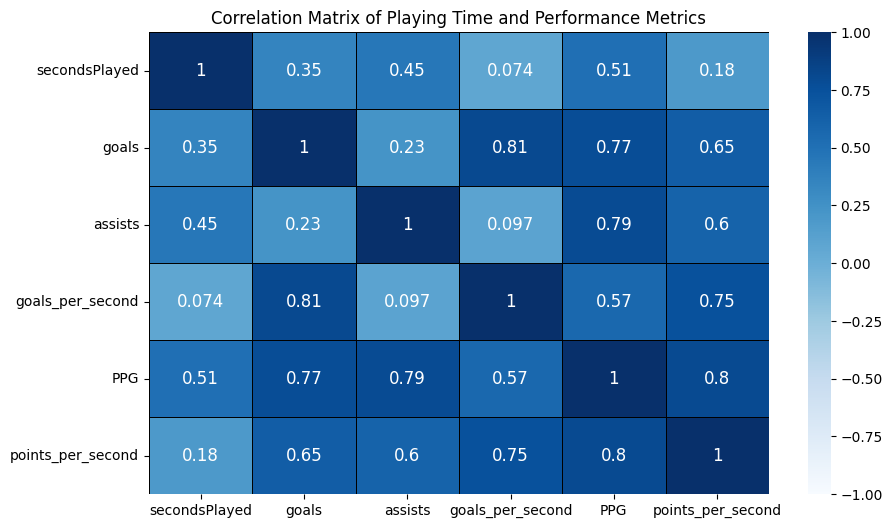

In [ ]:
playtime_corr_overall = playtime_ppg[columns]

corr_matrix_overall = playtime_corr_overall.corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix_overall, annot=True, cmap='Blues', vmin=-1, vmax=1, center=0,
            linewidths=0.5, linecolor='black', annot_kws={'fontsize': 12})
plt.title('Correlation Matrix of Playing Time and Performance Metrics')
plt.show()

There seems to be a moderate positive overall league correlation with playing time (secondsPlayed) and PPG of **0.51**.

In [ ]:
glorydf

firstName     lastName teamID  secondsPlayed  yardsReceived  \
0      Tanner     Halkyard  glory           1408            389   
1      Tanner     Halkyard  glory           1297            329   
2      Tanner     Halkyard  glory           1155            274   
3        Cole  Davis-Brand  glory            581            119   
4      Topher        Davis  glory            888            143   
..        ...          ...    ...            ...            ...   
463      Ryan    Woodhouse  glory            538              0   
464      Ryan    Woodhouse  glory            909              0   
465      Ryan    Woodhouse  glory            885              0   
466      Ryan    Woodhouse  glory            552              0   
467      Ryan    Woodhouse  glory            666              0   

     completion_percentage  goals  throwaway_percentage  \
0                  90.4762      6                4.7619   
1                  89.4737      6               10.5263   
2                 100.0000      5                0.0000   
3                  90.9091      1                9.0909   
4                 100.0000      5                0.0000   
..                     ...    ...                   ...   
463                 0.0000      0                0.0000   
464                 0.0000      0                0.0000   
465                 0.0000      0                0.0000   
466                 0.0000      0                0.0000   
467                 0.0000      0                0.0000   

     throw_yards_per_attempt  yardsThrown  yards_per_reception  assists  \
0                   4.904762          103            13.892857        5   
1                   8.631579          164            14.304348        4   
2                   6.416667           77            16.117647        3   
3                   8.272727          182             5.666667        3   
4                  12.555556          113            10.214286        1   
..                       ...          ...                  ...      ...   
463                      NaN            0                  NaN        0   
464                      NaN            0                  NaN        0   
465                      NaN            0                  NaN        0   
466                      NaN            0                  NaN        0   
467                      NaN            0                  NaN        0   

     goals_per_second  PPG  points_per_second  
0            0.004261   11           0.007812  
1            0.004626   10           0.007710  
2            0.004329    8           0.006926  
3            0.001721    4           0.006885  
4            0.005631    6           0.006757  
..                ...  ...                ...  
463          0.000000    0           0.000000  
464          0.000000    0           0.000000  
465          0.000000    0           0.000000  
466          0.000000    0           0.000000  
467          0.000000    0           0.000000  

[468 rows x 15 columns]

In [ ]:
ppg5_glory= glorydf[glorydf['PPG'] > 5]
ppg5_glory

firstName     lastName teamID  secondsPlayed  yardsReceived  \
0      Tanner     Halkyard  glory           1408            389   
1      Tanner     Halkyard  glory           1297            329   
2      Tanner     Halkyard  glory           1155            274   
4      Topher        Davis  glory            888            143   
5       Orion        Cable  glory           1403            212   
6      Tannor      Johnson  glory           1266            192   
7      Topher        Davis  glory           1282            251   
10     Topher        Davis  glory           1317            298   
11        Ray    Tetreault  glory           1488            336   
12   Benjamin        Sadok  glory           1349            272   
13       Cole  Davis-Brand  glory           1200            339   
14     Topher        Davis  glory           1385            162   
15     Tanner     Halkyard  glory           1417            316   
16   Benjamin        Sadok  glory           1425            222   
17      Orion        Cable  glory           1314            248   
19     Willie      Stewart  glory           1320            211   
22      Orion        Cable  glory           1511            360   
23   Benjamin        Sadok  glory           1716            218   
24       Cole  Davis-Brand  glory           1547            156   
26     Willie      Stewart  glory           1567            149   
27     Willie      Stewart  glory           1572            189   
28    Zachary       Burpee  glory           1409            219   
29     Tannor      Johnson  glory           1619            149   
32     Tanner     Halkyard  glory           1470            293   
33   Benjamin        Sadok  glory           1280             74   
35     Topher        Davis  glory           1309            156   
37      Henry      Babcock  glory           1349             94   
38   Benjamin        Sadok  glory           1350            202   
40        Ray    Tetreault  glory           1601            378   
41       Nick     Thompson  glory           1376            263   
44      Henry      Babcock  glory           1413            192   
47     Topher        Davis  glory           1430            376   
48        Ray    Tetreault  glory           1433            273   
49   Benjamin        Sadok  glory           1911            113   
52   Benjamin        Sadok  glory           1690            213   
53    Zachary       Burpee  glory           1452            217   
54   Benjamin        Sadok  glory           1732            398   
56   Benjamin        Sadok  glory           1741            297   
57       Cole  Davis-Brand  glory           1498            279   
58     Tanner     Halkyard  glory           1499            221   
59       Nick     Thompson  glory           1520            100   
61     Tannor      Johnson  glory           2041            304   
64       Cole  Davis-Brand  glory           1543            163   
69       Cole  Davis-Brand  glory           1618            152   
72   Benjamin        Sadok  glory           1944            291   
78     Willie      Stewart  glory           1748            393   
79     Anders        Olsen  glory           1752            207   
80     Tannor      Johnson  glory           1754            304   
92   Benjamin        Sadok  glory           1823            255   
110    Tannor      Johnson  glory           2009            295   

     completion_percentage  goals  throwaway_percentage  \
0                  90.4762      6                4.7619   
1                  89.4737      6               10.5263   
2                 100.0000      5                0.0000   
4                 100.0000      5                0.0000   
5                  72.7273      7                9.0909   
6                  96.0000      3                4.0000   
7                  94.1176      4                5.8824   
10                 89.4737      4                5.2632   
11                100.0000      6                0.0000

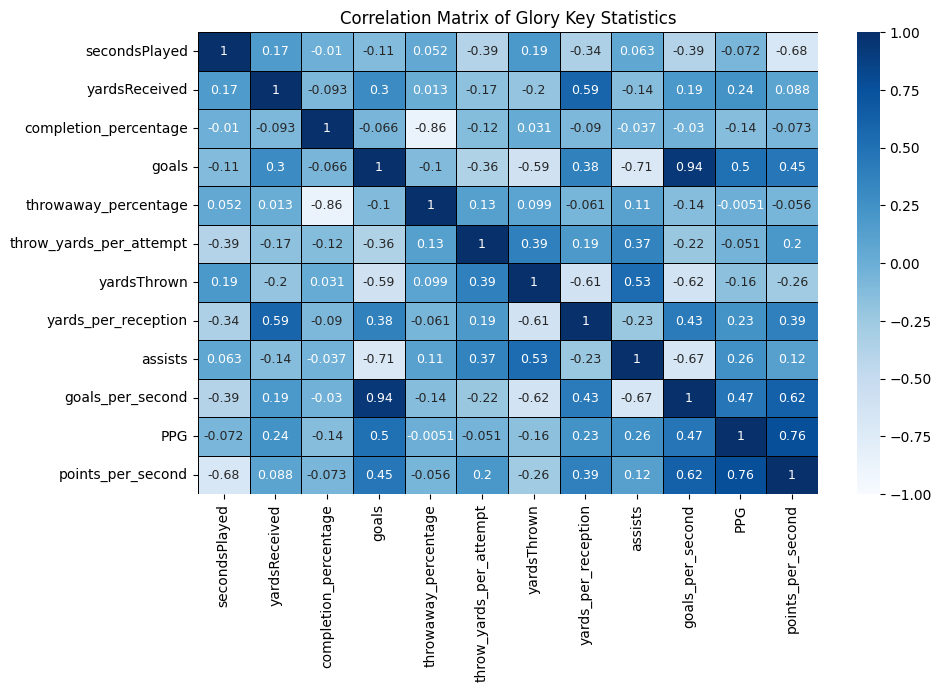

In [ ]:
columns= ['secondsPlayed','yardsReceived','completion_percentage','goals','throwaway_percentage','throw_yards_per_attempt','yardsThrown','yards_per_reception','assists','goals_per_second','PPG','points_per_second']
glorycorr = ppg5_glory[columns]

corr_matrix_glory = glorycorr.corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix_glory, annot=True, cmap='Blues', vmin=-1, vmax=1, center=0,
            linewidths=0.5, linecolor='black', annot_kws={'fontsize': 9})
plt.title('Correlation Matrix of Glory Key Statistics')
plt.show()

We see relevant positive correlation with PPG for the following attributes: yardsReceived (0.24) and yards_per_reception(0.23). For negative PPG correlation we see the following attributes: secondsPlayed (-0.072) and yardsThrown (-0.16).

Although these league correlations seem to be small, we are hoping it's the "little things" that make all the difference. As in most sports, it can come down to a small statistic or change in game play to achieve a better winning record.

## **Machine Learning Models**

**The goal is to predict a lineup as win for Boston Glory to play against certain teams using Logistic Regression**




**Feature Engineering**

Feature engineering on game outcomes

In [ ]:
/*Feature engineering on game outcomes*/
CREATE OR REPLACE TABLE `boston-glory-analytics.audl.game_outcome` AS
SELECT
  pgs.*,
  g.homeTeamID,
  g.awayTeamID,
  g.homeScore,
  g.awayScore,
  CASE
    WHEN g.homeTeamID = gm.teamID AND g.homeScore > g.awayScore THEN 1
    WHEN g.awayTeamID = gm.teamID AND g.awayScore > g.homeScore THEN 1
    ELSE 0
  END AS win
FROM
  `boston-glory-analytics.audl.performance_players` pgs
JOIN
  `boston-glory-analytics.audl.Games3` g
ON
  pgs.gameID = g.gameID
JOIN
  `boston-glory-analytics.audl.playergamestat3` gm
ON
  pgs.playerID = gm.playerID AND pgs.gameID = gm.gameID;


Feature engineering on player performance

In [ ]:
/*Feature engineering on player performance*/
CREATE OR REPLACE TABLE boston-glory-analytics.audl.performance_players  AS
SELECT
  gameID,
  playerID,
  SUM(goals) AS total_goals,
  SUM(assists) AS total_assists,

  SUM(completions) AS total_completions,
  SUM(throwAttempts) AS total_throw_attempts,
  SUM(blocks) AS total_blocks,
  SUM(yardsReceived) AS total_yards_received,
  SUM(yardsThrown) AS total_yards_thrown
FROM
  boston-glory-analytics.audl.playergamestat3
GROUP BY
  gameID,
  playerID;


**Transform Data**

In [ ]:
CREATE OR REPLACE TABLE boston-glory-analytics.audl.logistictraining_data AS
SELECT
  playerID,
  AVG(total_goals) AS avg_goals,
  AVG(total_assists) AS avg_assists,

  AVG(total_completions) AS avg_completions,
  AVG(total_throw_attempts) AS avg_throw_attempts,
  AVG(total_blocks) AS avg_blocks,
  AVG(total_yards_received) AS avg_yards_received,
  AVG(total_yards_thrown) AS avg_yards_thrown,
  win
FROM
  boston-glory-analytics.audl.game_outcome
GROUP BY
  playerID,
  win;


**Split Data into Training(70%) and Test Data(30%)**

In [ ]:
CREATE OR REPLACE TABLE `boston-glory-analytics.audl.logistic_data_split` AS
SELECT
  *,
  CASE
    WHEN RAND() <= 0.7 THEN 'TRAIN'
    ELSE 'TEST'
  END AS dataset
FROM
  `boston-glory-analytics.audl.logistictraining_data`;


**Creating two new dataset for training and testing dataset**

In [ ]:
-- Training Data
CREATE OR REPLACE TABLE `boston-glory-analytics.audl.logistic_training_data` AS
SELECT
  avg_goals,
  avg_assists,
  avg_completions,
  avg_throw_attempts,
  avg_blocks,
  avg_yards_received,
  avg_yards_thrown,
  win
FROM
  `boston-glory-analytics.audl.logistic_data_split`
WHERE
  dataset = 'TRAIN';

-- Testing Data
CREATE OR REPLACE TABLE `boston-glory-analytics.audl.logistic_testing_data` AS
SELECT
  avg_goals,
  avg_assists,
  avg_completions,
  avg_throw_attempts,
  avg_blocks,
  avg_yards_received,
  avg_yards_thrown,
  win
FROM
  `boston-glory-analytics.audl.logistic_data_split`
WHERE
  dataset = 'TEST';


**Training the Logistic Regression Model**

In [ ]:
CREATE OR REPLACE MODEL `boston-glory-analytics.audl.lineup_logistic_model`
OPTIONS(model_type='logistic_reg', input_label_cols=['win']) AS
SELECT
  avg_goals,
  avg_assists,
  avg_completions,
  avg_throw_attempts,
  avg_blocks,
  avg_yards_received,
  avg_yards_thrown,
  win
FROM
  `boston-glory-analytics.audl.logistic_training_data`;


**Evaluation of Model**

In [ ]:
SELECT
  *
FROM
  ML.EVALUATE(MODEL `boston-glory-analytics.audl.lineup_logistic_model`, (
    SELECT
      avg_goals,
      avg_assists,
      avg_completions,
      avg_throw_attempts,
      avg_blocks,
      avg_yards_received,
      avg_yards_thrown,
      win
    FROM
      `boston-glory-analytics.audl.logistic_testing_data`
  ));


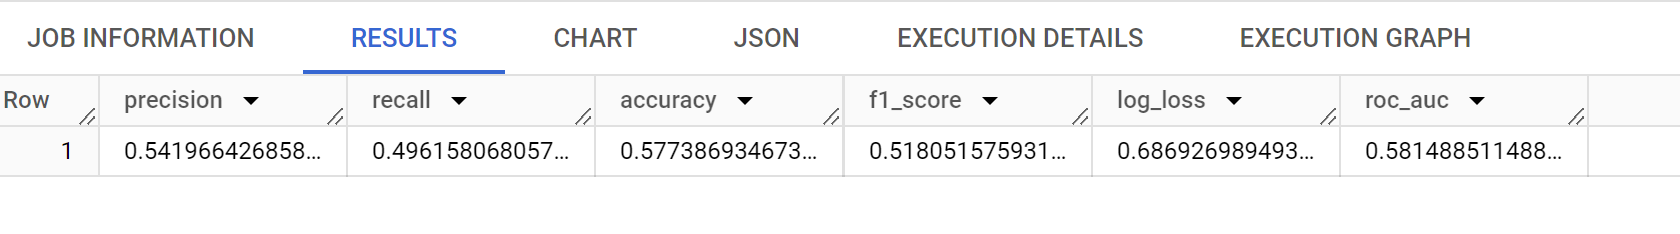

The current logistic regression model for predicting a win for Boston Glory demonstrates moderate performance. With a precision of 54.19%, the model correctly predicts a win just over half the time, but there's still a significant risk of false positives. The recall of 49.62% suggests that the model misses out on identifying a substantial portion of actual wins, leading to false negatives. An accuracy of 57.74% indicates the model is slightly better than random guessing, but there's room for improvement. The F1 score of 0.5181 reflects a moderate balance between precision and recall, but both are below ideal levels. The log loss of 0.6869 suggests that the model is not particularly confident in its predictions, which could mean the predicted probabilities aren't well-calibrated. The ROC AUC of 0.5815 indicates that the model is only marginally better than random guessing in distinguishing between wins and losses. Overall, while the model is functional, it would benefit from further tuning and enhancements to improve its predictive accuracy and reliability.

Audrey's model below

**Linear Regression to predict average yards per reception by player**

**Fill Null Values with Mean Values for Yards Per Reception and Throw Yards Per Attempt**-- This was necessary to evaluate the model, as NaN values were originally showing on the evaluation metrics.

In [ ]:
UPDATE `boston-glory-analytics.audl.PGSADV-AS1`
SET avg_yards_per_reception =
    (SELECT avg_yards_per_reception
     FROM (SELECT AVG(avg_yards_per_reception) AS avg_yards_per_reception
           FROM `boston-glory-analytics.audl.PGSADV-AS1`
           WHERE avg_yards_per_reception IS NOT NULL))
WHERE avg_yards_per_reception IS NULL;


UPDATE `boston-glory-analytics.audl.PGSADV-AS1`
SET avg_throw_yards_per_attempt =
    (SELECT avg_throw_yards_per_attempt
     FROM (SELECT AVG(avg_throw_yards_per_attempt) AS avg_throw_yards_per_attempt
           FROM `boston-glory-analytics.audl.PGSADV-AS1`
           WHERE avg_throw_yards_per_attempt IS NOT NULL))
WHERE avg_throw_yards_per_attempt IS NULL;

**Split Data into Training(70%) and Test Data(30%)**

In [ ]:
CREATE OR REPLACE TABLE `boston-glory-analytics.audl.training_yards_per_reception3`AS
SELECT *
FROM (
  SELECT
    *,
    CASE
      WHEN RAND() < 0.7 THEN 'TRAIN'
      ELSE 'TEST'
    END AS split
  FROM `boston-glory-analytics.audl.PGSADV-AS3`
)
WHERE split = 'TRAIN';

CREATE OR REPLACE TABLE `boston-glory-analytics.audl.testing_yards_per_reception3`AS
SELECT *
FROM (
  SELECT
    *,
    CASE
      WHEN RAND() < 0.7 THEN 'TRAIN'
      ELSE 'TEST'
    END AS split
  FROM `boston-glory-analytics.audl.PGSADV-AS3`
)
WHERE split = 'TEST';

**Training the Linear Regression Model**

In [ ]:
CREATE OR REPLACE MODEL `boston-glory-analytics.audl.yards_per_reception_linear_model3`
OPTIONS(
  model_type='linear_reg',
  input_label_cols=['avg_yards_per_reception']
) AS
SELECT
  total_assists,
  total_goals,
  total_hockeyAssists,
  total_throwaways,
  total_callahansThrown,
  total_yardsReceived,
  total_catches,
  total_callahans,
  total_pulls,
  total_obPulls,
  total_recordedPullsHangtime,
  total_oPointsPlayed,
  total_dPointsPlayed,
  total_dPointsScored,
  total_secondsPlayed,
  total_oOpportunities,
  total_oOpportunityScores,
  total_dOpportunities,
  total_dOpportunityStops,
  avg_completion_percentage,
  avg_throwaway_percentage,
  avg_hucks_percentage,
  total_total_yards,
  total_scoring_results_participated,
  avg_throw_yards_per_attempt
  avg_yards_per_reception
FROM
  `boston-glory-analytics.audl.training_yards_per_reception3`

**Linear regression model evaluation**

In [ ]:
SELECT
  *
FROM
  ML.EVALUATE(MODEL `boston-glory-analytics.audl.yards_per_reception_linear_model3`,
  (
    SELECT
      total_assists,
      total_goals,
      total_hockeyAssists,
      total_throwaways,
      total_callahansThrown,
      total_yardsReceived,
      total_catches,
      total_callahans,
      total_pulls,
      total_obPulls,
      total_recordedPullsHangtime,
      total_oPointsPlayed,
      total_dPointsPlayed,
      total_dPointsScored,
      total_secondsPlayed,
      total_oOpportunities,
      total_oOpportunityScores,
      total_dOpportunities,
      total_dOpportunityStops,
      avg_completion_percentage,
      avg_throwaway_percentage,
      avg_hucks_percentage,
      total_total_yards,
      total_scoring_results_participated,
      avg_throw_yards_per_attempt,
      avg_yards_per_reception
    FROM
      `boston-glory-analytics.audl.testing_yards_per_reception3`
  )
);

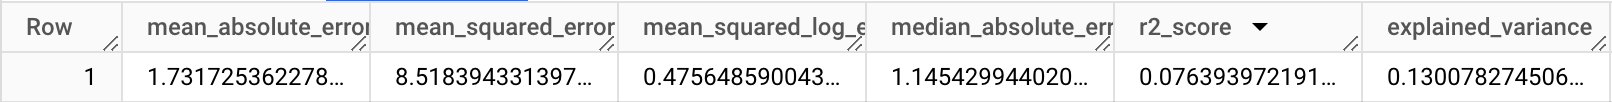

In [ ]:
SELECT
  predicted_avg_yards_per_reception,
  avg_yards_per_reception
FROM
  ML.PREDICT(MODEL `boston-glory-analytics.audl.yards_per_reception_linear_model3`,
  (
    SELECT
      total_assists,
      total_goals,
      total_hockeyAssists,
      total_throwaways,
      total_callahansThrown,
      total_yardsReceived,
      total_catches,
      total_callahans,
      total_pulls,
      total_obPulls,
      total_recordedPullsHangtime,
      total_oPointsPlayed,
      total_dPointsPlayed,
      total_dPointsScored,
      total_secondsPlayed,
      total_oOpportunities,
      total_oOpportunityScores,
      total_dOpportunities,
      total_dOpportunityStops,
      avg_completion_percentage,
      avg_throwaway_percentage,
      avg_hucks_percentage,
      total_total_yards,
      total_scoring_results_participated,
      avg_throw_yards_per_attempt,
      avg_yards_per_reception
    FROM
      `boston-glory-analytics.audl.yards_per_reception_gloryonly`
  )
);

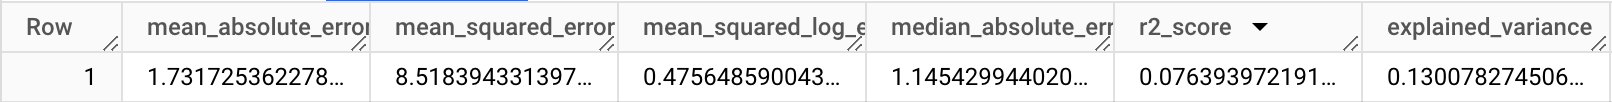

 The model demonstrates a mean absolute error (MAE) of 1.73, meaning the predictions are 1.73 points off from the actual value on average. The model's mean squared error (MSE) of 8.52 implies larger errors were present, while the median absolute error (MedAE) of 1.15 reflects a typical prediction error that is slightly more consistent. However, the model's performance is not ideal, as the R-squared value of 0.0764, suggests that 7.64% of the variance in the predicted average yards per reception is explained by the model. These results suggest that the model may be underfitting and needs further improvement.


End of Audrey's modeling.